# 6. 自定义数据读取方式
- torch.utils.data.Dataset与Dataloader的理解
- torchvision中的datasets
- torchvision ImageFolder
- torchvision transforms
----------

## 1. torch.utils.data.Dataset与torch.utils.data.DataLoader的理解
1. pytorch提供了一个数据读取的方法，其由两个类构成：torch.utils.data.Dataset和DataLoader
2. 我们要自定义自己数据读取的方法，就需要继承torch.utils.data.Dataset，并将其封装到DataLoader中
3. torch.utils.data.Dataset表示该数据集，继承该类可以重载其中的方法，实现多种数据读取及数据预处理方式
4. torch.utils.data.DataLoader 封装了Data对象，实现单（多）进程迭代器输出数据集

### 1.1 torch.utils.data.Dataset
1. 要自定义自己的Dataset类，至少要重载两个方法，\__len\__, \__getitem\__
2. \__len\__返回的是数据集的大小
3. \__getitem\__实现索引数据集中的某一个数据
4. 除了这两个基本功能，还可以在\__getitem\__时对数据进行预处理，或者是直接在硬盘中读取数据，对于超大的数据集还可以使用lmdb来读取

#### 下面将简单实现一个Tensor数据集

In [7]:
from torch.utils.data import DataLoader, Dataset
import torch

In [8]:
class TensorDataset(Dataset):
    # TensorDataset继承Dataset, 重载了__init__, __getitem__, __len__
    # 实现将一组Tensor数据对封装成Tensor数据集
    # 能够通过index得到数据集的数据，能够通过len，得到数据集大小
    
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)

In [9]:
# 生成数据
data_tensor = torch.randn(4, 3)
target_tensor = torch.rand(4)

# 将数据封装成Dataset
tensor_dataset = TensorDataset(data_tensor, target_tensor)

# 可使用索引调用数据
print 'tensor_data[0]: ', tensor_dataset[0]

# 可返回数据len
print 'len os tensor_dataset: ', len(tensor_dataset)

tensor_data[0]:  (
 0.6804
-1.2515
 1.6084
[torch.FloatTensor of size 3]
, 0.2058754563331604)
len os tensor_dataset:  4


### 1.2 torch.utils.data.Dataloader
1. Dataloader将Dataset或其子类封装成一个迭代器
2. 这个迭代器可以迭代输出Dataset的内容
3. 同时可以实现多进程、shuffle、不同采样策略，数据校对等等处理过程

#### 对上述的TensorDataset封装成Dataloader

In [14]:
tensor_dataloader = DataLoader(tensor_dataset,   # 封装的对象
                               batch_size=2,     # 输出的batchsize
                               shuffle=True,     # 随机输出
                               num_workers=0)    # 只有1个进程
# 输出一个batch
print 'one batch tensor data: ', iter(tensor_dataloader).next()
# 输出batch数量
print 'len of batchtensor: ', len(list(iter(tensor_dataloader)))

one batch tensor data:  [
 0.6804 -1.2515  1.6084
-0.1156 -1.1552  0.1866
[torch.FloatTensor of size 2x3]
, 
 0.2059
 0.6452
[torch.DoubleTensor of size 2]
]
len of batchtensor:  2


## 2.torchvision.datasets
1. pytorch专门针对视觉实现了一个torchvision包，里面包括了许多常用的CNN模型以及一些数据集
2. torchvision.datasets包含了MNIST，cifar10等数据集，他们都是通过继承上述Dataset类实现的

### 2.1 torchvision自带的数据集
#### 下面我见简单调用一下cifar数据集

In [34]:
import torchvision.datasets as dset
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
%matplotlib inline

def imshow(img, is_unnormlize=False):
    if is_unnormlize:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Files already downloaded and verified


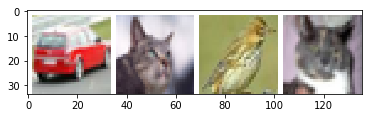

In [35]:
# 载入cifar数据集
trainset = dset.CIFAR10(root='../data',                  # 数据集路径
                        train=True,                      # 载入train set
                        download=True,                   # 如果未下载数据集，则自动下载。
                                                         # 建议直接下载后压缩到root的路径
                        transform=transforms.ToTensor()  # 转换成Tensor才能被封装为DataLoader
                        )

# 封装成loader
trainloader = DataLoader(trainset, batch_size=4,
                         shuffle=True, num_workers=2)

# 显示图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

### 2.2 直接从硬盘中载入自己的图像
torch.datasets包中的ImageFolder支持我们直接从硬盘中按照固定路径格式载入每张数据，其格式如下：
* 根目录/类别/图像

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```
* 我们以ants bees数据集为例：

In [39]:
antbee_dataset = dset.ImageFolder(root='../../hymenoptera_data/train/',
                                  transform=transforms.ToTensor())

# 输出类别名
print antbee_dataset.classes

['ants', 'bees']


## 3. torchvision.transforms
1. 在刚才，我们见到生成cifar数据集时有一个参数transform，这个参数就是实现各种预处理
2. 在torchvision.transforms中，有多种预测方式，如scale，centercrop
3. 我们可以使用Compose将这些预处理方式组成transforms list，对图像进行多种处理
4. 需要注意，由于这些transform是基于PIL的，因此Compose中，Scale等预处理需要先调用，ToTensor需要后与他们
5. 如果觉得torchvision自带的预处理不够多，可以使用https://github.com/ncullen93/torchsample 中的transforms

Files already downloaded and verified


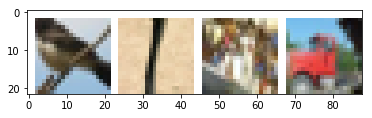

In [53]:
# 定义transform
transform = torchvision.transforms.Compose(
    [transforms.RandomCrop(20),
     transforms.ToTensor(),                       # ToTensor需要在预处理之后进行
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] )

# 载入cifar数据集
trainset = dset.CIFAR10(root='../data',                  # 数据集路径
                        train=True,                      # 载入train set
                        download=True,                   # 如果未下载数据集，则自动下载。
                                                         # 建议直接下载后压缩到root的路径
                        transform=transform              # 进行预处理
                        )

# 封装成loader
trainloader = DataLoader(trainset, batch_size=4,
                         shuffle=True, num_workers=2)

# 显示图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images), True)